# implementing yolov1 from scratch using keras tensorflow 2.0

#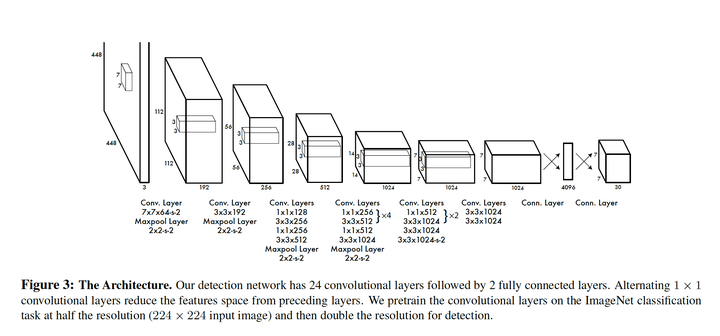 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### 下载数据

In [5]:
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

#!tar xvf VOCtrainval_06-Nov-2007.tar
#!tar xvf VOCtest_06-Nov-2007.tar

#!rm VOCtrainval_06-Nov-2007.tar
#!rm VOCtest_06-Nov-2007.tar

### 解析数据 从xml->txt

In [2]:
import argparse
import xml.etree.ElementTree as ET
import os

parser = argparse.ArgumentParser(description='Build Annotations.')
parser.add_argument('dir', default='..', help='Annotations.')

sets = [('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}


def convert_annotation(year, image_id, f):
    in_file = os.path.join('VOCdevkit/VOC%s/Annotations/%s.xml' % (year, image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        classes = list(classes_num.keys())
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        f.write(' ' + ','.join([str(a) for a in b]) + ',' + str(cls_id))

In [3]:
for year, image_set in sets:
  print(year, image_set)
  with open(os.path.join('VOCdevkit/VOC%s/ImageSets/Main/%s.txt' % (year, image_set)), 'r') as f:
      image_ids = f.read().strip().split()
  with open(os.path.join("VOCdevkit", '%s_%s.txt' % (year, image_set)), 'w') as f:
      for image_id in image_ids:
          f.write('%s/VOC%s/JPEGImages/%s.jpg' % ("VOCdevkit", year, image_id))
          convert_annotation(year, image_id, f)
          f.write('\n')

2007 train
2007 val
2007 test


接下来，准备一个函数来处理输入和输出. 输入图像大小尺寸是(448, 448, 3)，输出是(7, 7, 30)的张量.输出大小是基于公式 S x S x (B * 5 +C).

S X S 是将图像提取为多少个格子B的数量，每一个格点会有B个 bounding boxes，每个格点会有C个类别概率，表明该格点属于哪一个类别

In [4]:
import cv2 as cv
import numpy as np

def read(image_path, label):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_h, image_w = image.shape[0:2]
    image = cv.resize(image, (448, 448))
    image = image / 255.  # normal
    
    label_martix = np.zeros([7, 7, 30])  # S: 7, C: 20
    for l in label:
        l = l.split(',')
        l = np.array(l, dtype=np.int)
        xmin, ymin, xmax, ymax, cls = l  # 该处有物体
        x = (xmin + xmax) / 2 / image_w  # norm size to reduce the influence on box size
        y = (ymin + ymax) / 2 / image_h
        w = (xmax - xmin) / image_w
        h = (ymax - ymin) / image_h
        loc = [7 * x, 7 * y]  # 每个grid的左上角坐标
        loc_i = int(loc[1])  # 最左上角
        loc_j = int(loc[0])
        y = loc[1] - loc_i  # 归一化一下左上角坐标
        x = loc[0] - loc_j
        
        if label_martix[loc_i, loc_j, 24] == 0:  # box的cls
            label_martix[loc_i, loc_j, cls] = 1
            label_martix[loc_i, loc_j, 20:24] = [x, y, w, h]
            label_martix[loc_i, loc_j, 24] = 1
    return image, label_martix

### train model

定义一个数据生成器，每次返回一个batch

In [5]:
from tensorflow import keras

class My_Custom_Generator(keras.utils.Sequence):
  
  def __init__(self, images, labels, batch_size):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    train_image = []
    train_label = []

    for i in range(0, len(batch_x)):
      img_path = batch_x[i]
      label = batch_y[i]
      image, label_matrix = read(img_path, label)
      train_image.append(image)
      train_label.append(label_matrix)
    return np.array(train_image), np.array(train_label)

In [6]:
train_datasets = []
val_datasets = []

with open(os.path.join("VOCdevkit", '2007_train.txt'), 'r') as f:
    train_datasets = train_datasets + f.readlines()
    
with open(os.path.join("VOCdevkit", '2007_val.txt'), 'r') as f:
    val_datasets = val_datasets + f.readlines()


X_train = []
Y_train = []


X_val = []
Y_val = []

for item in train_datasets:
    item = item.replace("\n", "").split(" ")
    X_train.append(item[0])
    arr = []
    for i in range(1, len(item)):
        arr.append(item[i])
    Y_train.append(arr)

for item in val_datasets:
    item = item.replace("\n", "").split(" ")
    X_val.append(item[0])
    arr = []
    for i in range(1, len(item)):
        arr.append(item[i])
    Y_val.append(arr)

接下来，创建一个生成器实例  

In [7]:
batch_size = 16
my_training_batch_generator = My_Custom_Generator(X_train, Y_train, batch_size)

my_validation_batch_generator = My_Custom_Generator(X_val, Y_val, batch_size)

x_train, y_train = my_training_batch_generator.__getitem__(0)
x_val, y_val = my_validation_batch_generator.__getitem__(0)

print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(16, 448, 448, 3)
(16, 7, 7, 30)
(16, 448, 448, 3)
(16, 7, 7, 30)


### 定义一个定制的输出层

将输出reshape到对应的输出格式，因此定义一个定制的输出层
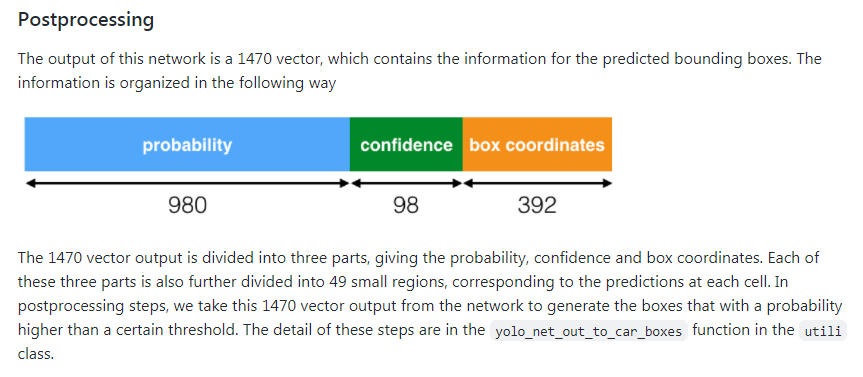

In [8]:
from tensorflow import keras
import keras.backend as K

class Yolo_Reshape(tf.keras.layers.Layer):
    
    def __init__(self, target_shape):
        super(Yolo_Reshape, self).__init__()
        self.target_shape = target_shape
        
    def get_config(self):
        config = super().get_config().copy()
        config.update(
        {'target_shape': self.target_shape}
        )
    
    def call(self, input):
        # grids 7x7
        S = [self.target_shape[0], self.target_shape[1]]
        
        # classes
        C = 20
        
        # no of bounding boxes per grid
        B = 2
        
        idx1 = S[0] * S[1] * C  # 7 x 7 x 20 = 980
        idx2 = idx1 + S[0] * S[1] * B  # 7 x 7 x 2 = 98
        
        # class probabilities  分类的方式  980
        class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0], ) + tuple([S[0], S[1], C]))
        class_probs = K.softmax(class_probs)
        
        # confidence  回归的方式 98
        confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0], ) + tuple([S[0], S[1], B]))
        confs = K.sigmoid(confs)
        
        # boxes  回归的方式
        boxes = K.reshape(input[:, idx2:], (K.shape(input)[0], ) + tuple([S[0], S[1], B * 4]))
        boxes = K.sigmoid(boxes)
        
        outputs = K.concatenate([class_probs, confs, boxes])
        return outputs
        

Using TensorFlow backend.


### 定义yolo v1 模型

照着论文定义yolo v1模型

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

lrelu = LeakyReLU(alpha=0.1)

nb_boxs = 1
grid_w = 7
grid_h = 7
cell_w = 64
cell_h = 64
img_w = grid_w * cell_w
img_h = grid_h * cell_h

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(7, 7), strides=(1, 1), input_shape=(img_h, img_w, 3), padding='same', activation=lrelu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=256, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=256, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=256, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=256, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=256, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=512, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=512, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=512, kernel_size=(1, 1), padding='same', activation=lrelu))
model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=lrelu))
model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation=lrelu))

model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(1470, activation='sigmoid'))
model.add(Yolo_Reshape(target_shape=(7,7,30)))
model.summary()          

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 448, 448, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 192)     110784    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 192)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     24704     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 256)     295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 256)     6

### 定义一个定制的学习率变化器 

定义一个callback 函数为学习率

In [10]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
    
    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.' )
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))

LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

### 定义损失函数

 定义损失函数， 可以参考 [loss function used in YOLO](https://hackernoon.com/understanding-yolo-f5a74bbc7967). 

实现是借鉴 [Github repo](https://github.com/JY-112553/yolov1-keras-voc).

In [11]:
import keras.backend as K

def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2
    
    return xy_min, xy_max

def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxs = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxs - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    
    union_areas = pred_areas + true_areas - intersect_areas  # 预测框面积 真实值面积 - 交叉面积
    iou_scores = intersect_areas / union_areas
    
    return iou_scores

def yolo_head(feats):
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])
    
    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))

    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
    box_wh = feats[..., 2:4] * 448

    return box_xy, box_wh

def yolo_loss(y_true, y_pred):
    # 30 维度： 20 类别， 2个box  每个box有五个值，4个坐标点及一个概率值
    label_class = y_true[..., :20]  # ? * 7 * 7 * 20
    label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
    response_mask = y_true[..., 24]  # ? * 7 * 7
    response_mask = K.expand_dims(response_mask)
    
    predict_class = y_pred[..., : 20]  # ? * 7 * 7 * 20
    predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
    predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8
    
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])
    
    label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
    label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  #  ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 *
    
    predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
    predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
    predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2.
    predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2, ? *
    
    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)   # ? * 7 * 7 * 2 * 1
    best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
    best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1
    
    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2
    
    no_object_loss = 0.5 * (1 - box_mask*response_mask) * K.square(0 - predict_trust)
    object_loss = box_mask * response_mask * K.square(1-predict_trust)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)
    
    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)
    
    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4]) # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])
    
    label_xy, label_wh = yolo_head(_label_box)
    predict_xy, predict_wh = yolo_head(_predict_box)
    
    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)
    
    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)
    
    loss = confidence_loss + class_loss + box_loss
    
    return loss 

### 增加一个callback 保存权重 

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True,  monitor='val_loss', mode='min')

### 编译模型

In [16]:
from tensorflow import keras
model.compile(loss=yolo_loss, optimizer='adam')

### 训练模型

In [17]:
model.fit(
    x=my_training_batch_generator,
    steps_per_epoch=int(len(X_train) // batch_size),
    epochs=10,
    verbose=1,
    workers=4,
    validation_data=my_validation_batch_generator,
    validation_steps=int(len(X_val) // batch_size),
    callbacks=[
        CustomLearningRateScheduler(lr_schedule),
        mcp_save]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 156 steps, validate for 156 steps

Epoch 00000: Learning rate is 0.0100.
Epoch 1/10
155/156 [============================>.] - ETA: 0s - loss: 386.6239

AttributeError: 'NoneType' object has no attribute 'items'